# 02_poisson_onnx
Poisson Jacobi step with ONNX parity check.

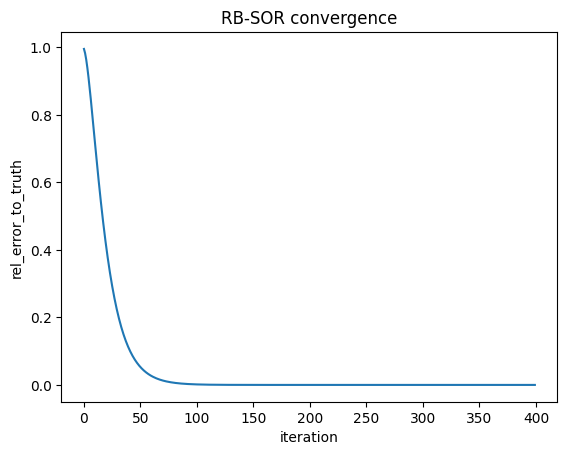

onnx_parity 6.461756925091322e-07
rel_to_truth 7.755641604489938e-07
PASS


In [1]:

import numpy as np, onnx, onnxruntime as ort
from onnx import helper as oh, TensorProto, numpy_helper as nph
import matplotlib.pyplot as plt
from pathlib import Path

N = 64
x = np.linspace(0.0, 1.0, N, dtype=np.float32)
X, Y = np.meshgrid(x, x, indexing="ij")
u_true = np.sin(np.pi*X)*np.sin(np.pi*Y)

sumN_true = np.zeros_like(u_true, dtype=np.float32)
sumN_true[1:-1,1:-1] = u_true[:-2,1:-1] + u_true[2:,1:-1] + u_true[1:-1,:-2] + u_true[1:-1,2:]
F = (sumN_true - 4.0*u_true).astype(np.float32)

M = np.zeros_like(u_true, dtype=np.float32)
M[1:-1,1:-1] = 1.0

R = np.zeros_like(u_true, dtype=np.float32)
B = np.zeros_like(u_true, dtype=np.float32)
for i in range(1,N-1):
    for j in range(1,N-1):
        if (i + j) % 2 == 0:
            R[i,j] = 1.0
        else:
            B[i,j] = 1.0

def rb_sor_np(U, F, R, B, steps, omega=1.9):
    U = U.copy()
    hist = []
    for _ in range(steps):
        S = np.zeros_like(U, dtype=np.float32)
        S[1:-1,1:-1] = U[:-2,1:-1] + U[2:,1:-1] + U[1:-1,:-2] + U[1:-1,2:]
        J = 0.25*(S - F)
        U = U + R*omega*(J - U)
        S = np.zeros_like(U, dtype=np.float32)
        S[1:-1,1:-1] = U[:-2,1:-1] + U[2:,1:-1] + U[1:-1,:-2] + U[1:-1,2:]
        J = 0.25*(S - F)
        U = U + B*omega*(J - U)
        num = np.linalg.norm((U - u_true).ravel())
        den = np.linalg.norm(u_true.ravel()) + 1e-12
        hist.append(num/den)
    return U, np.array(hist, dtype=np.float32)

U0 = np.zeros_like(u_true, dtype=np.float32)
steps = 400
U_np, hist = rb_sor_np(U0, F, R, B, steps)

def build_rb_sor_model(omega=1.9):
    Uv = oh.make_tensor_value_info("U", TensorProto.FLOAT, ["b","c","h","w"])
    Fv = oh.make_tensor_value_info("F", TensorProto.FLOAT, ["b","c","h","w"])
    Rv = oh.make_tensor_value_info("R", TensorProto.FLOAT, ["b","c","h","w"])
    Bv = oh.make_tensor_value_info("B", TensorProto.FLOAT, ["b","c","h","w"])
    Ov = oh.make_tensor_value_info("Out", TensorProto.FLOAT, ["b","c","h","w"])
    W = nph.from_array(np.array([[[[0,1,0],[1,0,1],[0,1,0]]]], dtype=np.float32), name="W")
    c025 = oh.make_tensor("c025", TensorProto.FLOAT, [], [0.25])
    comega = oh.make_tensor("comega", TensorProto.FLOAT, [], [float(omega)])
    nodes = []
    nodes.append(oh.make_node("Conv", ["U","W"], ["S1"], pads=[1,1,1,1]))
    nodes.append(oh.make_node("Sub", ["S1","F"], ["D1"]))
    nodes.append(oh.make_node("Constant", [], ["C025"], value=c025))
    nodes.append(oh.make_node("Mul", ["D1","C025"], ["J1"]))
    nodes.append(oh.make_node("Sub", ["J1","U"], ["E1"]))
    nodes.append(oh.make_node("Constant", [], ["COM"], value=comega))
    nodes.append(oh.make_node("Mul", ["E1","COM"], ["W1"]))
    nodes.append(oh.make_node("Mul", ["W1","R"], ["WR"]))
    nodes.append(oh.make_node("Add", ["U","WR"], ["Ur"]))
    nodes.append(oh.make_node("Conv", ["Ur","W"], ["S2"], pads=[1,1,1,1]))
    nodes.append(oh.make_node("Sub", ["S2","F"], ["D2"]))
    nodes.append(oh.make_node("Mul", ["D2","C025"], ["J2"]))
    nodes.append(oh.make_node("Sub", ["J2","Ur"], ["E2"]))
    nodes.append(oh.make_node("Mul", ["E2","COM"], ["W2"]))
    nodes.append(oh.make_node("Mul", ["W2","B"], ["WB"]))
    nodes.append(oh.make_node("Add", ["Ur","WB"], ["Out"]))
    g = oh.make_graph(nodes, "rb_sor", [Uv,Fv,Rv,Bv], [Ov], initializer=[W])
    m = oh.make_model(g, opset_imports=[oh.make_operatorsetid("",13)])
    onnx.checker.check_model(m)
    m.ir_version = 11
    return m

model = build_rb_sor_model()
ART = (Path.cwd().parent / "artifacts")
ART.mkdir(parents=True, exist_ok=True)
with open(str(ART / "poisson_jacobi.onnx"), "wb") as f:
    f.write(model.SerializeToString())

sess = ort.InferenceSession(model.SerializeToString(), providers=["CPUExecutionProvider"])
U = U0[None,None].astype(np.float32)
F4 = F[None,None]
R4 = R[None,None]
B4 = B[None,None]
for _ in range(steps):
    U = sess.run(None, {"U":U,"F":F4,"R":R4,"B":B4})[0]
U_ort = U[0,0]

rel_parity = np.linalg.norm((U_np - U_ort).ravel())/(np.linalg.norm(U_np.ravel()) + 1e-12)
rel_true = np.linalg.norm((U_np - u_true).ravel())/(np.linalg.norm(u_true.ravel()) + 1e-12)

plt.figure()
plt.plot(hist)
plt.xlabel("iteration")
plt.ylabel("rel_error_to_truth")
plt.title("RB-SOR convergence")
plt.show()

print("onnx_parity", float(rel_parity))
print("rel_to_truth", float(rel_true))
assert rel_parity < 1e-6
assert rel_true < 5e-2
print("PASS")
